[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/hometask_SyntheticRubber.ipynb)

In [2]:
##### При работе в Colab
!pip install yfinance requests

  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached charset_normalizer-2.1.0-py3-none-any.whl (39 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


In [3]:
!pip install pathlib ruamel-yaml

In [1]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm

In [3]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [3]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах


# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [6]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
year = '2022'
month = '05'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)
df.head()

,date,grade,masa,rm,us,tone
0,2022-05-31,SMR CV,Noon,1157.50,269.20,Slightly steadier
1,2022-05-31,SMR L,Noon,1147.50,266.90,Slightly steadier
2,2022-05-31,SMR 5,Noon,740.00,172.10,Slightly steadier
3,2022-05-31,SMR GP,Noon,737.00,171.40,Slightly steadier
4,2022-05-31,SMR 10,Noon,730.00,169.80,Slightly steadier


In [4]:
# собираем данные по ценам на каучук за год
months = ['0' + str(i) if i < 10 else str(i) for i in range(1, 13)]
year = 2021
df_rubber = pd.DataFrame()
for month in tqdm(months):
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
    res = requests.get(url)
    rj = res.json()
    temp_df = pd.json_normalize(rj)
    df_rubber = df_rubber.append(temp_df)
df_rubber

  0%|          | 0/12 [00:00<?, ?it/s]

,date,grade,masa,rm,us,tone
0,2021-01-29,SMR CV,Noon,906.50,227.75,Quietly Steady
1,2021-01-29,SMR L,Noon,896.50,225.25,Quietly Steady
2,2021-01-29,SMR 5,Noon,641.50,161.20,Quietly Steady
3,2021-01-29,SMR GP,Noon,638.50,160.45,Quietly Steady
4,2021-01-29,SMR 10,Noon,631.50,158.65,Quietly Steady
...,...,...,...,...,...,...
142,2021-12-01,SMR 5,Noon,749.50,181.30,Steady
143,2021-12-01,SMR GP,Noon,746.50,180.60,Steady
144,2021-12-01,SMR 10,Noon,739.50,178.90,Steady
145,2021-12-01,SMR 20,Noon,737.50,178.40,Steady


In [5]:
df_r = df_rubber.copy()

In [6]:
df_dict = {}
for ticker in tqdm(['EURUSD=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df
df_dict

  0%|          | 0/1 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


{'EURUSD=X': Date
 2003-12-31    1.231372
 2004-01-31    1.260813
 2004-02-29    1.264357
 2004-03-31    1.226723
 2004-04-30    1.199692
                 ...   
 2022-04-30    1.082745
 2022-05-31    1.057322
 2022-06-30    1.057670
 2022-07-31    1.019509
 2022-08-31    1.020615
 Freq: M, Name: Close, Length: 225, dtype: float64}

In [7]:
exchange_rate_df = pd.concat(df_dict.values(), axis=1)
exchange_rate_df.columns = ['EURUSD']
exchange_rate_df = exchange_rate_df.loc['2021-01-01':'2021-12-31'].copy()
exchange_rate_df = exchange_rate_df.reset_index()
exchange_rate_df['Date'] = pd.to_datetime(exchange_rate_df['Date']).dt.to_period('M')
exchange_rate_df

,Date,EURUSD
0,2021-01,1.217785
1,2021-02,1.209898
2,2021-03,1.191474
3,2021-04,1.195960
4,2021-05,1.214025
5,2021-06,1.205959
6,2021-07,1.182493
7,2021-08,1.177090
8,2021-09,1.177784
9,2021-10,1.160063


In [8]:
df_r

,date,grade,masa,rm,us,tone
0,2021-01-29,SMR CV,Noon,906.50,227.75,Quietly Steady
1,2021-01-29,SMR L,Noon,896.50,225.25,Quietly Steady
2,2021-01-29,SMR 5,Noon,641.50,161.20,Quietly Steady
3,2021-01-29,SMR GP,Noon,638.50,160.45,Quietly Steady
4,2021-01-29,SMR 10,Noon,631.50,158.65,Quietly Steady
...,...,...,...,...,...,...
142,2021-12-01,SMR 5,Noon,749.50,181.30,Steady
143,2021-12-01,SMR GP,Noon,746.50,180.60,Steady
144,2021-12-01,SMR 10,Noon,739.50,178.90,Steady
145,2021-12-01,SMR 20,Noon,737.50,178.40,Steady


In [9]:
df_r['us'] = pd.to_numeric(df_r.us)
df_r['rm'] = pd.to_numeric(df_r.rm)
df_r['date'] = pd.to_datetime(df_r['date']).dt.to_period('M')

In [10]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687 entries, 0 to 146
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   date    1687 non-null   period[M]
 1   grade   1687 non-null   object   
 2   masa    1687 non-null   object   
 3   rm      1687 non-null   float64  
 4   us      1687 non-null   float64  
 5   tone    1687 non-null   object   
dtypes: float64(2), object(3), period[M](1)
memory usage: 92.3+ KB


In [11]:
df_r = df_r[df_r.grade == 'SMR 20']

In [12]:
df_r = df_r.groupby(['date', 'grade']).mean()[['us', 'rm']]

In [13]:
df_2 = pd.DataFrame(df_r)
df_2 = df_2.reset_index()
df_2

,date,grade,us,rm
0,2021-01,SMR 20,158.397368,628.578947
1,2021-02,SMR 20,169.161765,672.676471
2,2021-03,SMR 20,175.245652,707.891304
3,2021-04,SMR 20,164.717500,667.850000
4,2021-05,SMR 20,169.091176,686.088235
5,2021-06,SMR 20,164.507143,668.857143
6,2021-07,SMR 20,164.321429,678.690476
7,2021-08,SMR 20,172.667500,717.650000
8,2021-09,SMR 20,163.226190,668.976190
9,2021-10,SMR 20,174.385000,714.075000


In [14]:
df_2 = df_2.merge(exchange_rate_df, left_on='date', right_on='Date')

In [15]:
df_2['EUR'] = df_2.us / df_2.EURUSD

In [16]:
df_2.drop(columns=['Date', 'EURUSD'], inplace=True)

In [17]:
df_2 = df_2.set_index('date')

In [18]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2021-01 to 2021-12
Freq: M
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   grade   12 non-null     object 
 1   us      12 non-null     float64
 2   rm      12 non-null     float64
 3   EUR     12 non-null     float64
dtypes: float64(3), object(1)
memory usage: 480.0+ bytes


In [19]:
df_2.index = df_2.index.astype(str)
df_2

,grade,us,rm,EUR
date,,,,
2021-01,SMR 20,158.397368,628.578947,130.070017
2021-02,SMR 20,169.161765,672.676471,139.814912
2021-03,SMR 20,175.245652,707.891304,147.083060
2021-04,SMR 20,164.717500,667.850000,137.728303
2021-05,SMR 20,169.091176,686.088235,139.281485
2021-06,SMR 20,164.507143,668.857143,136.411902
2021-07,SMR 20,164.321429,678.690476,138.961918
2021-08,SMR 20,172.667500,717.650000,146.690107
2021-09,SMR 20,163.226190,668.976190,138.587562


In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

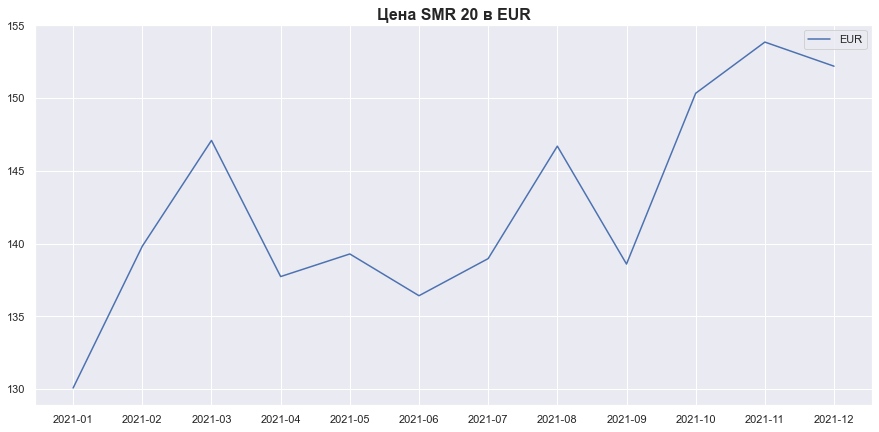

In [21]:
plt.title('Цена SMR 20 в EUR', fontsize=16, fontweight='bold')
plt.plot(df_2['EUR'], label='EUR')
plt.legend()
plt.show()

In [22]:
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'formula': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'formula': 'monthly'}}

In [23]:
discounts

{'up to 100': 0.01, 'up to 300': 0.05, '300 plus': 0.1}

In [24]:
customers.items()

dict_items([('Monty', {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'}), ('Triangle', {'location': 'CN', 'volumes': 30, 'formula': 'monthly'}), ('Stone', {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'}), ('Poly', {'location': 'EU', 'volumes': 70, 'formula': 'monthly'})])

In [34]:
def calculation_price(df, client: str, values: dict) -> pd.DataFrame:
    """
    Функция расчета возможной цены с доставкой для каждого 
    клиента с учетом локации и объемов закупки.
    
    :param df: Датафрейм со стоимостью каучука
    :param client: имя клиента
    :param values: данные о клиенте
    """
    LOGISTIC_COST = {'EUR': 30,
                 'us': 130}
    main_df = df.copy()
    
    # расчет цены каучука с доставкой в европу
    if values.get('location') == 'EU':
        if values.get('volumes') < 100:
            main_df[f'{client}_price_eur'] = main_df['EUR'] * (1 - discounts.get('up to 100'))
        elif values.get('volumes') >= 100 and values.get('volumes') < 300:
            main_df[f'{client}_price_eur'] = main_df['EUR'] * (1 - discounts.get('up to 300'))
        else:
            main_df[f'{client}_price_eur'] = main_df['EUR'] * (1 - discounts.get('300 plus'))
        main_df[f'{client}_price_eur'] = main_df[f'{client}_price_eur'] + LOGISTIC_COST.get('EUR')
        main_df = main_df[f'{client}_price_eur']
        
    # расчет цены каучука с доставкой в китай    
    if values.get('location') == 'CN':
            if values.get('volumes') < 100:
                main_df[f'{client}_price_us'] = main_df['us'] * (1 - discounts.get('up to 100'))
            elif values.get('volumes') >= 100 and values.get('volumes') < 300:
                main_df[f'{client}_price_us'] = main_df['us'] * (1 - discounts.get('up to 300'))
            else:
                main_df[f'{client}_price_us'] = main_df['us'] * (1 - discounts.get('300 plus'))
            main_df[f'{client}_price_us'] = main_df[f'{client}_price_us'] + LOGISTIC_COST.get('us')
            main_df = main_df[f'{client}_price_us']
    return main_df
    
        
def write_clients_file(customers: dict, discounts: dict, df):
    with pd.ExcelWriter('price_proposals.xlsx') as writer:
        for client, values in customers.items():
            client_df = calculation_price(df, client, values)
            client_df.to_excel(writer, sheet_name=client)

In [35]:
write_clients_file(customers, discounts, df_2)

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [3]:
# import yourpackage

# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage